회귀분석의 의미 
하나 이상의 독립변수가 종속변수에 미치는 영향을 직선 형태로 표현하고 , 그 관계를 이용해  값을 예측하는 분석방법.

-복립변수들이 종속변수에 미치는 영향을 추정한다.
-규명된 함수식을 이용하여 설명변수들의 변화로부터 종속변수의 변화를 예측한다.
-독립변수X에 대하여 종속변수Y들사이의 관계를 수학적 모형을 이용하여 규명한다.

정리하면 y=f(x)일 때 방정식 f(x)를 규명하여 독립적인 값 x에 따라 y가 어떻게 변화하는지 예측하는 것.
이를 통해 변수들 사이의 인과관계를 밝히고 모형을 적합하여 관심있는 변수를 예측하거나 추론하기 위한 분석방법



In [ ]:
from hossam import load_data
from pandas import DataFrame, melt
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

from statsmodels.formula.api import ols

import statsmodels.api as sm

from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr

In [ ]:
my_dpi = 200                                    # 이미지 선명도(100~300)
font_path = "./NotoSansKR-Regular.ttf"          # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)               # 폰트의 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname=font_path)  # 폰트의 속성을 읽어옴
font_name = font_prop.get_name()                # 읽어온 속성에서 폰트의 이름만 추출     
plt.rcParams['font.family'] = font_name         # 그래프에 한글 폰트 적용
plt.rcParams['font.size'] = 10                  # 기본 폰트크기
plt.rcParams['axes.unicode_minus'] = False      # 그래프에 마이너스 깨짐 방지(한글환경에서 필수)


In [ ]:
origin = load_data('cars')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")

print("\n=====타입확인 =====")
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/lab12_/cars.xlsx
[desc] 자동차의 속도(speed)에 따른 제동거리(dist) 조사 데이터 (출처: R 기본 데이터)

field    description
-------  -------------
speed    속도
dist     제동거리


===== 데이터 크기 확인 =====
데이터셋 크기: (50, 2)
열 개수: 2

=====타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   speed   50 non-null     int64
 1   dist    50 non-null     int64
dtypes: int64(2)
memory usage: 932.0 bytes
None


,speed,dist
0,4,2
1,4,10
2,7,4
3,7,22
4,8,16


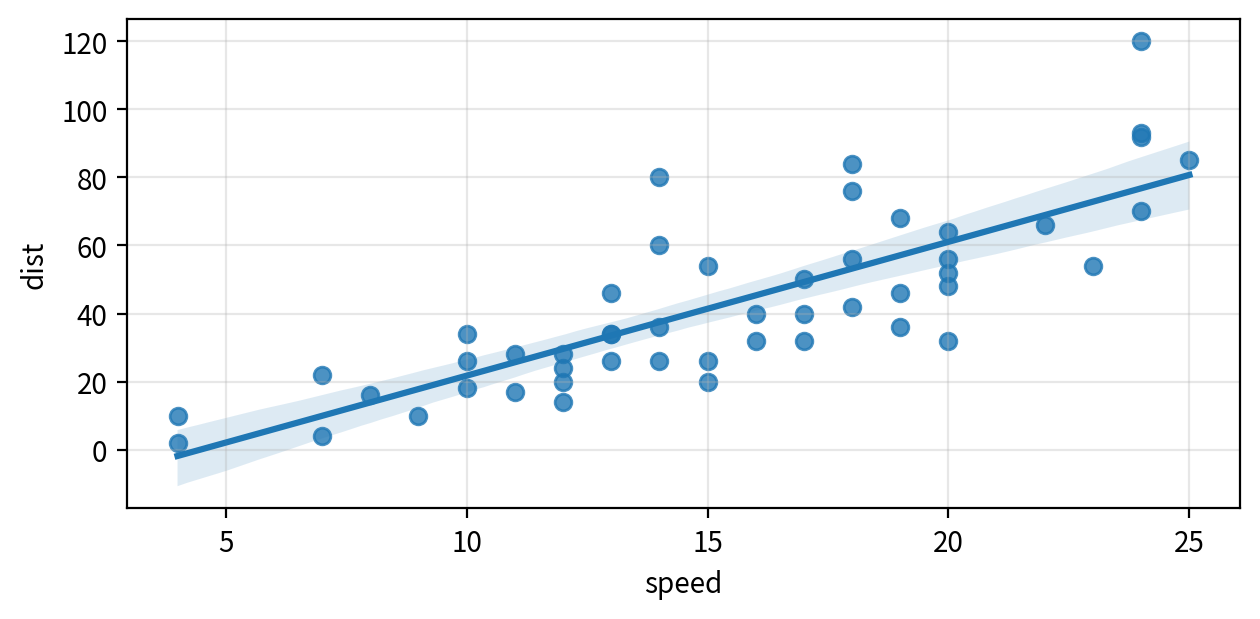

In [ ]:
width_px = 1280
height_px = 640
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

sb.regplot(data=origin, x='speed', y='dist')


ax.grid(True,alpha=0.3)


plt.tight_layout()
plt.show()
plt.close()

자동차 속도와 제동거리는 선형성을 충족하고 양의 상관관계가 있는것으로 보인다.

,original_skew,log_skew,outliers(|z|>3),log_recommended
speed,-0.11751,-1.668586,0,False
dist,0.806895,-1.384501,1,False


이상치가 발견되어 스피어만 상관계수 사용


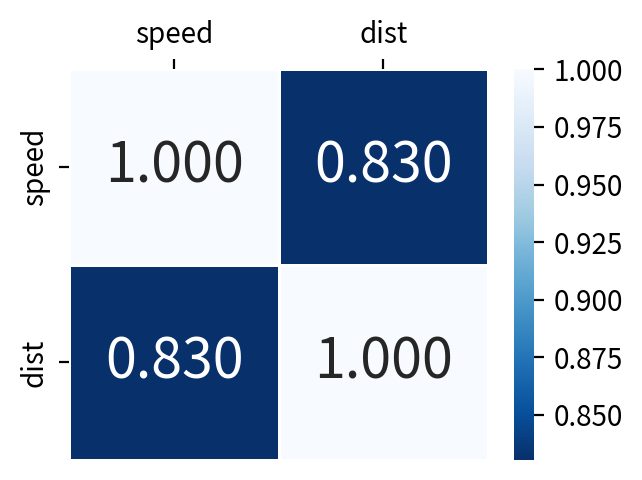

데이터 점검 과정에서 비선형 관계 가능성 또는 이상치 영향이 확인되어 스피어만 상관계수를 사용하였다.

분석 결과, 스피어만 상관계수는 r = 0.830, p = 0.000(으)로 나타나 두 변수 간 양의 단조 관계가 존재함을 확인하였다.


In [ ]:
xname= 'speed'
yname='dist'

# 선형성 가정 확인 -> 산점도 그래프를 통해 시각적으로 확인

linearity_ok = True

#이상치와 왜도 검정
data = origin[[xname, yname]]
results = {}

for col in data.columns:
    temp = data[col].dropna()

    # 왜도 계산
    skew_original = temp.skew()

    #Z-score 기반 이상치 탐지(|z|>3)
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores)>3))

    #로그 변환 후 왜도 계산 (음수 대비 +1)
    data_log = np.log1p(temp-temp.min()+1)
    skew_log = data_log.skew()

    #로그 변환 필요 여부 판단
    need_log = (abs(skew_original)>1) and (abs(skew_log)<abs(skew_original))
    
    results[col] = {
        'original_skew':skew_original,
        'log_skew': skew_log,
        'outliers(|z|>3)':outlier_count,
        'log_recommended': need_log,
    }

results_df = DataFrame(results).T
display(results_df)

#이상치 점검 결과
outlier_flag = len((results_df['outliers(|z|>3)']>0))>0
if outlier_flag:
    print("이상치가 발견되어 스피어만 상관계수 사용")
else:
    print("이상치가 발견되지 않아 피어슨 상관계수 사용")

#상관분석
report = f"본 분석에서는 {xname}과 {yname}간 상관관계를 검토하였다.\n\n"

#상관계수 선택
if linearity_ok and not outlier_flag:
    chosen = 'pearson'
    corr, pval = pearsonr(origin[xname], origin[yname])
    rationale='선형성 만족 + 왜도/이상치 영향 작음으로 판단'

    if pval>0.05:
        report += "데이터 점검 결과, 두 변수의 관계는 통계적으로 유의하지 않았다."
    else:
        report +=f"데이터 점검 결과, 두 변수의 관계는 선형적이며 이상치의 영향도 크지 않아 피어슨 상관계수를 사용하였다.\n\n분석 결과, 피어슨 상관계수는 r = {corr:0.3f}, p = {pval:0.3f}(으)로 나타나 두 변수 간 {"양의 상관" if corr > 0 else
"음의 상관"} 관계가 통계적으로 유의함을 확인하였다."
else:
    chosen = 'spearman'
    corr, pval = spearmanr(origin[xname], origin[yname])
    rationale='비선형(또는 이상치 영향)가능성 고려'

    if pval>0.05:
        report +="데이터 점검결과,  두 변수의 관계는 통계적으로 유의하지 않았다."
    else:
         report = f"데이터 점검 과정에서 비선형 관계 가능성 또는 이상치 영향이 확인되어 스피어만 상관계수를 사용하였다.\n\n분석 결과, 스피어만 상관계수는 r = {corr:0.3f}, p = {pval:0.3f}(으)로 나타나 두 변수 간 {"양의 단조" if
corr > 0 else "음의 단조"} 관계가 존재함을 확인하였다."
         
# 결과 시각화
corr_matrix = origin[[xname, yname]].corr(method=chosen)


width_px = 650
height_px = 500
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

sb.heatmap(data=corr_matrix, annot=True, fmt="0.3f", linewidth=0.5, cmap="Blues_r", annot_kws={"size":20})


ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.tick_top() #X축의 변수 이름을 상단으로 이동



plt.tight_layout()
plt.show()
plt.close()

# 결과 보고 출력
print(report)

In [ ]:
x = origin[['speed']]
x.head()

,speed
0,4
1,4
2,7
3,7
4,8


In [ ]:
y = origin["dist"]
y.head()

0     2
1    10
2     4
3    22
4    16
Name: dist, dtype: int64

In [ ]:
X=sm.add_constant(x)
X.head()

,const,speed
0,1.0,4
1,1.0,4
2,1.0,7
3,1.0,7
4,1.0,8


In [ ]:
#OLS 모델 객체 생성
#-> 이 단계에서는 아직 학습 되지 않은 '모형의 틀'만 만들어짐
model = sm.OLS(y,X)
#모델 적합(Fit)
#->데이터를 이용해 회귀계수를 추정하고, 모델을 완성하는 단계
fit = model.fit()

#적합된 모델 객체의 분석 결과 확인
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   dist   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     89.57
Date:                   목, 11 12 2025   Prob (F-statistic):           1.49e-12
Time:                        11:13:49   Log-Likelihood:                -206.58
No. Observations:                  50   AIC:                             417.2
Df Residuals:                      48   BIC:                             421.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.5791      6.758     -2.601      0.0

In [ ]:
#학습 모델 객체 생성
model = ols("dist~ speed", data=origin)

#모델 적합
fit =model.fit()

#분석결과 확인
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   dist   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     89.57
Date:                   목, 11 12 2025   Prob (F-statistic):           1.49e-12
Time:                        11:14:59   Log-Likelihood:                -206.58
No. Observations:                  50   AIC:                             417.2
Df Residuals:                      48   BIC:                             421.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -17.5791      6.758     -2.601      0.0

In [ ]:
df = origin.copy()
df['y_pred'] = fit.predict(X)
df.head()

,speed,dist,y_pred
0,4,2,-1.849460
1,4,10,-1.849460
2,7,4,9.947766
3,7,22,9.947766
4,8,16,13.880175


In [ ]:
df_melt = df.melt(
    id_vars = "speed",
    value_vars = ["dist", "y_pred"],
    var_name = "variable",
    value_name="value"
)
df_melt.head()

,speed,variable,value
0,4,dist,2.0
1,4,dist,10.0
2,7,dist,4.0
3,7,dist,22.0
4,8,dist,16.0


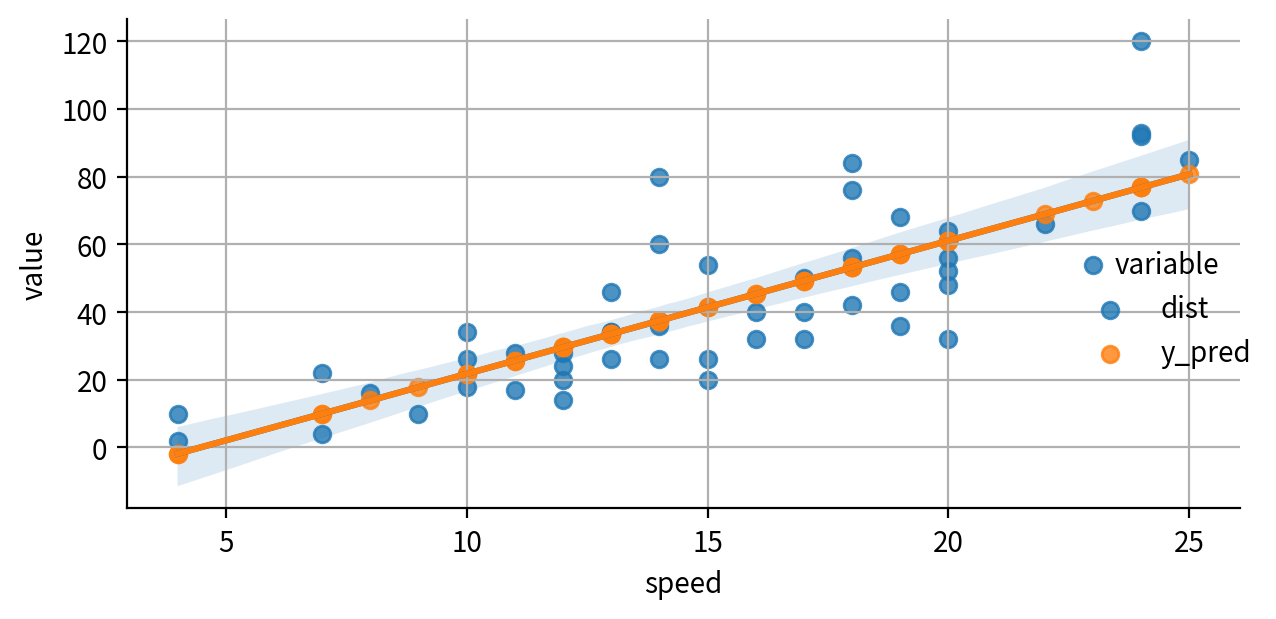

In [ ]:

width_px = 1280
height_px = 640
figsize = (width_px/ my_dpi, height_px/ my_dpi)

g = sb.lmplot(data=df_melt, x='speed', y='value', hue='variable')
g.fig.set_dpi(my_dpi)
g.fig.set_figwidth(figsize[0])
g.fig.set_figheight(figsize[1])


plt.grid()


plt.tight_layout()
plt.show()
plt.close()